In [4]:
import pandas as pd
import os 
import nltk


## Fonctions importantes pour le nettoyage 

In [1]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # enlever URLs
    text = re.sub(r"[^a-zA-Zàâçéèêëîïôûùüÿñæœ\s]", " ", text)  # enlever ponctuation/chiffres
    return text

### Fonction qui suppriment les stopwords

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
x = [
    "abord","plus","faire","quand","juste","ce","soir","salut","rien","merci","enfin", "afin", "ah", "aie", "ainsi", "allo", "allô", "alors", "après", "assez", "attendu", "aucun", "aucune", "aucuns",
    "aujourd", "aujourd'hui", "auquel", "aura", "auront", "aussi", "autre", "autres", "aux", "auxquelles", "auxquels", "avaient",
    "avais", "avait", "avant", "avec", "avoir", "avons", "ayant", "bah", "bas", "beaucoup", "bien", "c", "c'est", "ça", "car",
    "ce", "ceci", "cela", "ces", "cet","peut", "cette", "ceux", "ceux-ci", "ceux-là", "chaque", "chez", "chose", "ci", "comme", "comment",
    "contre", "couic", "d", "dans", "de", "debout", "dedans", "dehors", "def", "depuis", "derrière", "des", "désormais", "desquelles",
    "desquels", "dessous", "dessus", "deux", "deuxième", "devant", "devers", "devra", "devront", "difficile", "dire", "dit", "dite",
    "dits", "divers", "diverse", "diverses", "doit", "doivent", "donc", "dont", "dos", "d'autres", "du", "duquel", "duquelles",
    "duquels", "durant", "e", "eh", "elle", "elle-même", "elles", "elles-mêmes", "en", "encore", "entre", "envers", "environ",
    "es", "est", "est-ce", "et", "etant", "etc", "étaient", "étais", "était", "étant", "être", "eu", "eue", "eues", "eux", "eux-mêmes",
    "excepté", "existe", "existe-t-il", "f", "faut", "faut-il", "femme", "femmes", "feront", "fête", "fêtes", "fin", "fini", "finir", "finit",
    "finitive", "finitives", "fois", "font", "forcément", "fort", "forte", "fortes", "forts", "fou", "fouiller", "fouillé", "fouillée",
    "fouillés", "fous", "fut", "sans","peux","peut","peu","matin","toutes","mettre","jour","tout","tous","ta","bonjour","gens","moi","la", "fait","fut-ce", "fut-il", "fut-elle", "fut-on", "fut-ils","si","ici","où","là","très","parce","va","ca","oui","non","tout","toute"
] + list("abcdefghijklmnopqrstuvwxyz") 
stop_words = set(stopwords.words('french'))
stop_words = stop_words | set(x)
def remove_stopwords(text):
    words = text.split()
    words_clean = [w for w in words if w.lower() not in stop_words]
    return " ".join(words_clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 ### Load Datasets

In [50]:
import os
import pandas as pd

folder1 = "scraped_messages_1509/"
folder2 = "scraped_messages_1809/"
output_folder = "merged_messages1"

os.makedirs(output_folder, exist_ok=True)

# Lister tous les fichiers CSV dans chaque dossier
files1 = set(f for f in os.listdir(folder1) if f.endswith(".csv"))
files2 = set(f for f in os.listdir(folder2) if f.endswith(".csv"))

# Intersection pour fichiers présents dans les deux dossiers
common_files = files1.intersection(files2)

for filename in common_files:
    file1 = os.path.join(folder1, filename)
    file2 = os.path.join(folder2, filename)

    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    merged = pd.concat([df1, df2], ignore_index=True)
    merged = merged.drop_duplicates(subset=["message_id", "date"])
    merged = merged.sort_values(by="date")

    output_file = os.path.join(output_folder, filename)
    merged.to_csv(output_file, index=False)
    print(f"Fichier fusionné sauvegardé : {output_file}")


Fichier fusionné sauvegardé : merged_messages1\messages_Saint_Malo.csv
Fichier fusionné sauvegardé : merged_messages1\messages_Lyon.csv
Fichier fusionné sauvegardé : merged_messages1\messages_15__Cantal.csv
Fichier fusionné sauvegardé : merged_messages1\messages_23__Creuse.csv
Fichier fusionné sauvegardé : merged_messages1\messages_PAYS_DE_LA_LOIRE.csv
Fichier fusionné sauvegardé : merged_messages1\messages_Bayeux.csv
Fichier fusionné sauvegardé : merged_messages1\messages_68__HautRhin.csv
Fichier fusionné sauvegardé : merged_messages1\messages_AUVERGNERHNEALPES.csv
Fichier fusionné sauvegardé : merged_messages1\messages_Autun.csv
Fichier fusionné sauvegardé : merged_messages1\messages_24__Dordogne.csv
Fichier fusionné sauvegardé : merged_messages1\messages_Metz.csv
Fichier fusionné sauvegardé : merged_messages1\messages_69__Rhne.csv
Fichier fusionné sauvegardé : merged_messages1\messages_Ancenis.csv
Fichier fusionné sauvegardé : merged_messages1\messages_BOURGOGNEFRANCHECOMTE.csv
Fich

In [51]:
import os
import pandas as pd

folder1 = "scraped_messages_1509/"
folder2 = "scraped_messages_1809/"
output_folder = "merged_messages2"

os.makedirs(output_folder, exist_ok=True)

# Lister tous les fichiers CSV dans chaque dossier
files1 = set(f for f in os.listdir(folder1) if f.endswith(".csv"))
files2 = set(f for f in os.listdir(folder2) if f.endswith(".csv"))

# Tous les fichiers (union)
all_files = files1.union(files2)

for filename in all_files:
    dfs = []
    
    # Lire fichier de folder1 si présent
    if filename in files1:
        df1 = pd.read_csv(os.path.join(folder1, filename))
        df1['source_folder'] = folder1  # optionnel, pour savoir d'où vient la ligne
        dfs.append(df1)
    
    # Lire fichier de folder2 si présent
    if filename in files2:
        df2 = pd.read_csv(os.path.join(folder2, filename))
        df2['source_folder'] = folder2  # optionnel
        dfs.append(df2)
    
    # Concaténation et nettoyage
    merged = pd.concat(dfs, ignore_index=True)
    merged = merged.drop_duplicates(subset=["message_id", "date"])
    merged = merged.sort_values(by="date")
    
    # Sauvegarde
    output_file = os.path.join(output_folder, filename)
    merged.to_csv(output_file, index=False)
    print(f"Fichier fusionné sauvegardé : {output_file}")


Fichier fusionné sauvegardé : merged_messages2\messages_Valenciennes.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Lyon.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Alençon.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Mâcon__Cluny__Charolles.csv
Fichier fusionné sauvegardé : merged_messages2\messages_15__Cantal.csv
Fichier fusionné sauvegardé : merged_messages2\messages_23__Creuse.csv
Fichier fusionné sauvegardé : merged_messages2\messages_PAYS_DE_LA_LOIRE.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Bayeux.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Chalon__Creusot__Montceau.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Villeurbanne.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Metz.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Ancenis.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Mazamet.csv
Fichier fusionné sauvegardé : merged_messages2\messages_29__Fini

Fichier fusionné sauvegardé : merged_messages2\messages_EstLyonnais_Bron_SaintPriest_VǸnissieux_DǸcines_Chassieu.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Marseille_Est.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Haut_béarn.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Nantes_Agglomération.csv
Fichier fusionné sauvegardé : merged_messages2\messages_25__Doubs.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Mǽcon__Cluny__Charolles.csv
Fichier fusionné sauvegardé : merged_messages2\messages_La_rochesurYon.csv
Fichier fusionné sauvegardé : merged_messages2\messages_45__Loiret.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Bocage_virois.csv
Fichier fusionné sauvegardé : merged_messages2\messages_Normandie.csv
Fichier fusionné sauvegardé : merged_messages2\messages_41__LoiretCher.csv
Fichier fusionné sauvegardé : merged_messages2\messages_73__Savoie.csv
Fichier fusionné sauvegardé : merged_messages2\messages_L8217le_de_

In [ ]:
data1 = pd.read_csv("")

In [4]:

# chemins vers dossiers, à modifier en fonction de l'environnement de travail
folder1 = "scraped_messages_1509/"
folder2 = "scraped_messages_1809/"
output_folder = "merged_messages1"

os.makedirs(output_folder, exist_ok=True)

# on récupère la liste des fichiers CSV du premier dossier
for filename in os.listdir(folder1):
    if filename.endswith(".csv") and filename in os.listdir(folder2):
        file1 = os.path.join(folder1, filename)
        file2 = os.path.join(folder2, filename)

        df1 = pd.read_csv(file1)
        df2 = pd.read_csv(file2)

        merged = pd.concat([df1, df2], ignore_index=True)
        # suppression des doublons sur message_id & date
        merged = merged.drop_duplicates(subset=["message_id", "date"])
        merged = merged.sort_values(by = "date")

        output_file = os.path.join(output_folder, filename)
        merged.to_csv(output_file, index=False)
        print(f"Fichier fusionné sauvegardé : {output_file}")

Fichier fusionné sauvegardé : merged_messages1\messages_15__Cantal.csv
Fichier fusionné sauvegardé : merged_messages1\messages_23__Creuse.csv
Fichier fusionné sauvegardé : merged_messages1\messages_24__Dordogne.csv
Fichier fusionné sauvegardé : merged_messages1\messages_26__Drme.csv
Fichier fusionné sauvegardé : merged_messages1\messages_33__Gironde.csv
Fichier fusionné sauvegardé : merged_messages1\messages_38__Isre.csv
Fichier fusionné sauvegardé : merged_messages1\messages_41__LoiretCher.csv
Fichier fusionné sauvegardé : merged_messages1\messages_42__Loire.csv
Fichier fusionné sauvegardé : merged_messages1\messages_43__HauteLoire.csv
Fichier fusionné sauvegardé : merged_messages1\messages_63__PuydeDme.csv
Fichier fusionné sauvegardé : merged_messages1\messages_68__HautRhin.csv
Fichier fusionné sauvegardé : merged_messages1\messages_69__Rhne.csv
Fichier fusionné sauvegardé : merged_messages1\messages_73__Savoie.csv
Fichier fusionné sauvegardé : merged_messages1\messages_74__HauteSavo

In [52]:
input_folder = "merged_messages2/"
output_file = "all_merged_messages.csv"
csv_files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

dfs = []
for file in csv_files:
    path = os.path.join(input_folder,file)
    df = pd.read_csv(path)
    dfs.append(df)
final_merged = pd.concat(dfs,ignore_index = True)
final_merged = final_merged.sort_values(by="date")
final_merged.to_csv(output_file,index =False)
print(f"les fichiers ont été fusionnés dans :{output_file}")

les fichiers ont été fusionnés dans :all_merged_messages.csv


In [5]:
data = pd.read_csv("all_merged_messages.csv")

In [103]:
data["chat_name"]

6         INDIGNONS NOUS NOUVELLE AQUITAINE 10 SEPTEMBRE
7         INDIGNONS NOUS NOUVELLE AQUITAINE 10 SEPTEMBRE
8         INDIGNONS NOUS NOUVELLE AQUITAINE 10 SEPTEMBRE
9         INDIGNONS NOUS NOUVELLE AQUITAINE 10 SEPTEMBRE
10        INDIGNONS NOUS NOUVELLE AQUITAINE 10 SEPTEMBRE
                               ...                      
313745                             Indignons-nous Cholet
313746                             Indignons-nous Cholet
313747                             Indignons-nous Cholet
313748                      Indignons nous 71500 Louhans
313751                      Indignons nous 71500 Louhans
Name: chat_name, Length: 241796, dtype: object

In [55]:
data["date"] = pd.to_datetime(data["date"])
data_filtered = data[data["date"] >= "2025-06-01"]
first_date = data_filtered["date"].min()
last_date = data_filtered["date"].max()
n_messages = data_filtered.shape[0]

# Fréquence de messages par jour
freq = data_filtered.groupby(["date", "chat_name"]).size().reset_index(name="count")

# Stats descriptives
print("📊 Statistiques descriptives :")
print(f"- Date du premier message : {first_date}")
print(f"- Date du dernier message : {last_date}")
print(f"- Nombre total de messages : {n_messages}")
print("\n- Fréquence de messages par jour :")
print(freq_per_day)  # n’affiche que les 5 premiers jours


📊 Statistiques descriptives :
- Date du premier message : 2025-07-24 09:08:11+00:00
- Date du dernier message : 2025-09-18 17:28:45+00:00
- Nombre total de messages : 313292

- Fréquence de messages par jour :
date
2025-07-25       13
2025-07-26       39
2025-07-27      492
2025-07-28      295
2025-07-29      770
2025-07-30      874
2025-07-31      606
2025-08-01      280
2025-08-02      212
2025-08-03      638
2025-08-04      416
2025-08-05      444
2025-08-06      492
2025-08-07      522
2025-08-08      400
2025-08-09      311
2025-08-10      293
2025-08-11      372
2025-08-12      431
2025-08-13      474
2025-08-14      684
2025-08-15      765
2025-08-16      681
2025-08-17      947
2025-08-18      673
2025-08-19      937
2025-08-20     1071
2025-08-21     1256
2025-08-22     1063
2025-08-23     1061
2025-08-24     1339
2025-08-25     1637
2025-08-26     1443
2025-08-27     1599
2025-08-28     1670
2025-08-29     2024
2025-08-30     1477
2025-08-31     1469
2025-09-01     2023
2025-

In [84]:
messages_per_user = data1.groupby('sender_id').size().sort_values(ascending=False)

In [82]:
data1 = pd.read_csv("all_merged_messages.csv", dtype={'sender_id': str, 'message_id': str})


In [78]:
messages_per_user.head().index.astype("int")

Int64Index([1192879456, -2147483648, 57521972, -2147483648, -2147483648], dtype='int64', name='sender_id')

In [90]:
messages_per_user.head().index[0]

'57521972.0'

In [91]:
top_user = messages_per_user.head().index[0]

In [99]:
user_messages = data1[data1['sender_id'] == top_user]

In [100]:
top_user

'57521972.0'

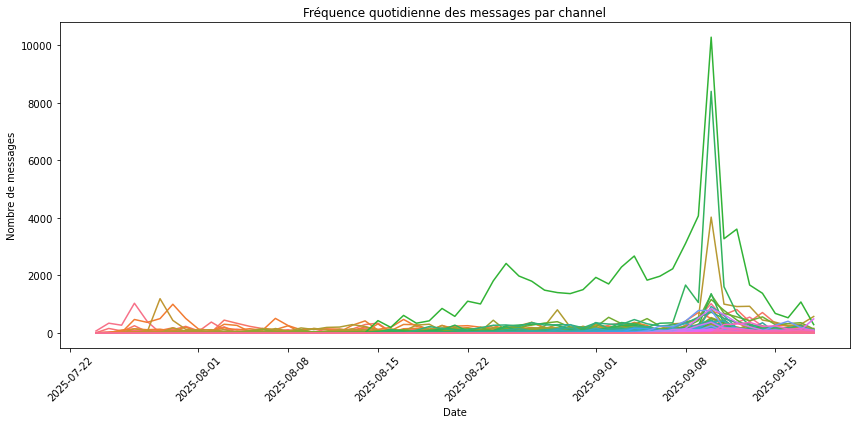

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Grouper par jour et channel
data_filtered['day'] = data_filtered['date'].dt.date
freq = data_filtered.groupby(['day', 'chat_name']).size().reset_index(name='count')

# Créer un index complet de dates pour chaque channel
all_days = pd.date_range(start=freq['day'].min(), end=freq['day'].max())
channels = freq['chat_name'].unique()
full_index = pd.MultiIndex.from_product([all_days, channels], names=['day', 'chat_name'])
freq = freq.set_index(['day','chat_name']).reindex(full_index, fill_value=0).reset_index()

top_channels = freq.groupby('chat_name')['count'].sum().sort_values(ascending=False).head(5).index

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=freq, x='day', y='count', hue='chat_name', legend = False)
plt.xticks(rotation=45)
plt.ylabel("Nombre de messages")
plt.xlabel("Date")
plt.title("Fréquence quotidienne des messages par channel")
plt.tight_layout()
plt.show()


In [106]:
print(top_channels)

Index(['INDIGNONS NOUS NOUVELLE AQUITAINE 10 SEPTEMBRE', 'PARIS ET ALENTOURS',
       '10S25 - Lyon', 'INDIGNONS NOUS BRETAGNE 10 Septembre',
       'INDIGNONS NOUS Puy-de-Dôme (63) 10 septembre'],
      dtype='object', name='chat_name')


 #### Applications des fonctions créées tout à l'heure 

In [6]:
data["clean"] = data["text"].apply(clean_text)
data["clean_stopwords"] = data["clean"].apply(remove_stopwords)

In [125]:
from collections import Counter

all_words = " ".join(data["clean_stopwords"]).split()
counter = Counter(all_words)

# 20 mots les plus fréquents
print(counter.most_common(20))


[('ag', 24766), ('mouvement', 21092), ('septembre', 21088), ('groupe', 20990), ('actions', 16557), ('personnes', 15414), ('place', 14531), ('monde', 14367), ('point', 11949), ('demain', 11017), ('action', 10792), ('pense', 9363), ('déjà', 9247), ('grève', 8386), ('temps', 8357), ('voir', 8125), ('france', 7912), ('telegram', 7711), ('lieu', 7702), ('personne', 7648)]


In [107]:
pip install --upgrade pillow


  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\Admin\\anaconda3\\Lib\\site-packages\\~il\\_imaging.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



#### On gère les lignes qui n'ont que très peu de mots (souvent des non-sens comme "jzzjz")

In [126]:
data = data[data["clean_stopwords"].str.split().str.len() >= 3].copy()

## Début de l'analyse du texte

## Ici on combine TfIDF à LDA (Latent Dirichlet Allocation) 
TfIDF est une méthode de vectorisation, le texte étant par définition une suite de caractères, il faut trouver un moyen de le numériser tout en gardant le contexte et la fréquence d'apparitions des termes. TfIDF prend un mot dans un Document( pour nous un message = un Document) et retourne sa fréquence dans le corpus suivant la fonction : $$ Tf_{ij} = \frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}}$$ où $f_{t,d}$ correspond à la fréquence d'apparition du mot $t$ dans le document $d$. La fréquence inverse est donnée par $$Idf_i = log(\frac{|D|}{|d, t_i \in d|}), \text{avec |D| le nombre total de messages}$$. Au final TfIDF est donnée par $$ TfIDF_{ij} = Tf_{ij}\cdot Idf_i$$

#### LDA
L'algorithme LDA (Latent Dirichlet Allocation) permet d'analyser un corpus de document et permet de faire de la classification rapidement. L'algorithme divise en "topics" le document et assigne à chaque mot un topic. (Voir le papier original pour l'implémentation, je n'ai pas eu le temps de regarder !)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

texts = data['clean_stopwords'].dropna().astype(str) #remove NAs

vectorizer = TfidfVectorizer(max_df=0.9, min_df=5) #les paramètres permettent de supprimer des termes trop/pas assez fréquents de l'analyse
X = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

# =========================
#  Modèle LDA
# =========================
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# =========================
# =========================
no_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTopic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# =========================
# =========================
topic_values = lda.transform(X)
data['dominant_topic'] = topic_values.argmax(axis=1)

# =========================
#  WordCloud par topic
# =========================
for topic_idx, topic in enumerate(lda.components_):
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-50 - 1:-1]}  # top 50 mots
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud Topic {topic_idx}")
    plt.show()


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names_out'

In [130]:
!pip install --user pyLDAvis

  Using cached pyLDAvis-3.4.0-py3-none-any.whl (2.6 MB)
  Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
  Using cached pandas-2.0.3-cp38-cp38-win_amd64.whl (10.8 MB)
  Using cached gensim-4.3.3-cp38-cp38-win_amd64.whl (24.0 MB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached smart_open-7.3.1-py3-none-any.whl (61 kB)
  Using cached scipy-1.10.1-cp38-cp38-win_amd64.whl (42.2 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [134]:
import pyLDAvis
import pyLDAvis.sklearn

# Préparer la visualisation
pyLDAvis.enable_notebook()  # pour Jupyter/Colab
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')  # mds='tsne' pour mieux répartir les topics

# Afficher la visualisation interactive
panel


C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [133]:
pip install --user scikit-learn==0.24.2


C:\Users\Admin\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


## Embedding
C'est une autre méthode de vectorisation, qui garde le contexte et le sens des mots, mais requiert bien plus de calculs

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
# -------------------------------
# MiniLM est rapide et léger (384 dimensions)
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# -------------------------------
# 4. Calcul des embeddings par batch
# -------------------------------
batch_size = 5000
embeddings = []

for start_idx in tqdm(range(0, len(data), batch_size)):
    end_idx = min(start_idx + batch_size, len(data))
    batch_texts = data['clean'].iloc[start_idx:end_idx].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
    embeddings.append(batch_embeddings)

# Fusionner tous les batches en un seul array
embeddings = np.vstack(embeddings)
print("Shape des embeddings :", embeddings.shape)  # (150000, 384)

In [ ]:
emb_df = pd.concat([data.reset_index(drop=True), pd.DataFrame(embeddings)], axis=1)
table = pa.Table.from_pandas(emb_df)
pq.write_table(table, "messages_with_embeddings.parquet")

print("Embeddings calculés et stockés avec succès !")

#### Lire le fichier parquet

In [ ]:

df_emb = pd.read_parquet("messages_with_embeddings.parquet",engine = "fastparquet")
print(df_emb.head())

In [ ]:
columns_list = [  #Liste qui contient chaque colonne qui n'est pas une des dimensions du embedding (à faire avant avec pd.col)
    "chat",
    "chat_name",
    "message_id",
    "date",
    "sender_id",
    "text",
    "reply_to",
    "clean",
    "clean_stopword",
    "nb_mots_champ",
    "somme_mots",
    "nb_champ_relatif",
    "clean_no_stop"
]
  # adapter selon tes colonnes
embedding_columns = df_emb.columns.difference(columns_list)

X = df_emb[embedding_columns].values

# Normalisation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## clustering par K-means
from sklearn.cluster import KMeans

n_clusters = 10  # tu peux ajuster
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_emb['cluster'] = kmeans.fit_predict(X_scaled)

print(df_emb[['text', 'cluster']].head())



### Representation graphique du clustering, problème étant que l'on joue avec des données de 380 dimensions.
On utilise le package umap

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2, random_state=42,unique = True)
X_umap = reducer.fit_transform(X_scaled)

import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

df_emb['x'] = X_umap[:,0]
df_emb['y'] = X_umap[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_emb, x='x', y='y', hue='cluster', palette='tab10', s=50, alpha=0.8)
plt.title("Clustering des messages")
plt.show()
